In [1]:
#hide
from fastbook import *
import fastinference
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG
from sklearn.model_selection import train_test_split
pd.options.display.max_rows = 20
pd.options.display.max_columns = 8
from fastai.tabular.all import *

In [3]:
#cpu is definitely faster and also creating way better results (issue that i dont understand) will stick to cpu on mac 
#dtype = torch.float
#device = torch.device("mps")

# Tabular Modeling

### Using a Neural Network

## Standardised

In [9]:
df_nn = pd.read_csv('../Data/Training/DISCOV_Invasea_V3.csv', low_memory=False,sep=";")

output_name = '../models/DISCOV_InvaSea_V3.pkl'

In [10]:
df_nn = df_nn[df_nn.True_Class != "Xanthophyceae"]

In [11]:
df_nn

,True_Class,Reflectance_444,Reflectance_475,Reflectance_531,...,Reflectance_Stan_740,Reflectance_Stan_842,NDVI_Stan,NDVI
0,Sediment,2423,2993,3510,...,0.668986,1.0,0.519637,0.234067
1,Sediment,2343,2972,3644,...,0.703349,1.0,0.541369,0.260277
2,Sediment,2465,2927,3584,...,0.896997,1.0,0.450696,0.180913
3,Sediment,2416,3050,3753,...,0.749339,1.0,0.455894,0.195845
4,Sediment,2330,2986,3676,...,0.647324,1.0,0.536614,0.258427
...,...,...,...,...,...,...,...,...,...
1160729,Magnoliopsida,1256,1337,1749,...,0.888889,1.0,0.908621,0.527704
1160730,Magnoliopsida,1169,1134,1587,...,0.804939,1.0,0.867692,0.567749
1160731,Magnoliopsida,1240,1221,1611,...,0.720914,1.0,0.866498,0.571628
1160732,Magnoliopsida,1287,1148,1538,...,0.701568,1.0,0.890480,0.564760


In [12]:
dep_var = "True_Class"
splits = RandomSplitter()(df_nn)

In [13]:
cont_nn,cat_nn = cont_cat_split(df_nn, dep_var=dep_var)

In [14]:
procs_nn = [FillMissing]
to_nn = TabularPandas(df_nn, procs_nn, cat_nn, cont_nn,
                      splits=splits, y_names=dep_var, y_block=CategoryBlock())

In [15]:
dls = to_nn.dataloaders()
dls.valid.show_batch()

,Reflectance_444,Reflectance_475,Reflectance_531,Reflectance_560,Reflectance_650,Reflectance_668,Reflectance_705,Reflectance_717,Reflectance_740,Reflectance_842,Reflectance_Stan_444,Reflectance_Stan_475,Reflectance_Stan_531,Reflectance_Stan_560,Reflectance_Stan_650,Reflectance_Stan_668,Reflectance_Stan_705,Reflectance_Stan_717,Reflectance_Stan_740,Reflectance_Stan_842,NDVI_Stan,NDVI,True_Class
0,2318.0,2650.0,3478.0,3879.0,3491.0,2809.0,4518.0,4782.0,4952.0,6180.0,0.000000,0.085966,0.300362,0.404195,0.303729,0.127136,0.569653,0.638011,0.682030,1.000000,0.774408,0.375014,Bacillariophyceae
1,848.0,906.0,1533.0,1682.0,1458.0,1177.0,2779.0,3297.0,3881.0,4227.0,0.000000,0.017165,0.202723,0.246819,0.180527,0.097366,0.571471,0.724771,0.897603,1.000000,0.822546,0.564397,Magnoliopsida
2,574.0,725.0,880.0,1197.0,1079.0,1097.0,1232.0,1285.0,1096.0,1427.0,0.000000,0.177022,0.358734,0.730363,0.592028,0.613130,0.771395,0.833529,0.611958,1.000000,0.239826,0.130745,Water
3,535.0,559.0,755.0,811.0,937.0,700.0,1855.0,2160.0,2523.0,2939.0,0.000000,0.009983,0.091514,0.114809,0.167221,0.068636,0.549085,0.675957,0.826955,1.000000,0.871545,0.615279,Rhodophyta
4,1582.0,1693.0,2307.0,3071.0,2182.0,2187.0,3929.0,5038.0,5503.0,6485.0,0.000000,0.022639,0.147869,0.303692,0.122374,0.123394,0.478687,0.704875,0.799714,1.000000,0.780320,0.495618,Magnoliopsida
5,484.0,583.0,582.0,734.0,731.0,559.0,1532.0,3109.0,4332.0,7672.0,0.000000,0.013773,0.013634,0.034780,0.034363,0.010434,0.145799,0.365192,0.535337,1.000000,0.979347,0.864172,Phaeophyta
6,2339.0,2966.0,3714.0,4161.0,3960.0,3477.0,4235.0,4784.0,4720.0,6055.0,0.000000,0.168730,0.370022,0.490312,0.436222,0.306243,0.510226,0.657966,0.640743,1.000000,0.531108,0.270457,Sediment
7,368.0,497.0,773.0,991.0,1035.0,1053.0,1048.0,1066.0,522.0,775.0,0.000000,0.184814,0.580229,0.892550,0.955587,0.981375,0.974212,1.000000,0.220630,0.583095,-0.254579,-0.152079,Water
8,1295.0,1414.0,1723.0,2068.0,1901.0,1549.0,3072.0,4021.0,4190.0,5528.0,0.000000,0.028112,0.101110,0.182613,0.143161,0.060005,0.419797,0.643988,0.683912,1.000000,0.886784,0.562244,Rhodophyta
9,525.0,504.0,750.0,717.0,836.0,686.0,1434.0,2432.0,4985.0,7767.0,0.002891,0.000000,0.033870,0.029327,0.045711,0.025059,0.128046,0.265455,0.616963,1.000000,0.951108,0.837691,Phaeophyta


In [16]:
y = to_nn.train.y
y.min(),y.max()

(0, 7)

In [12]:
#dls.device=device

In [17]:
learn = tabular_learner(dls,n_out=10)

SuggestedLRs(valley=0.0008317637839354575)

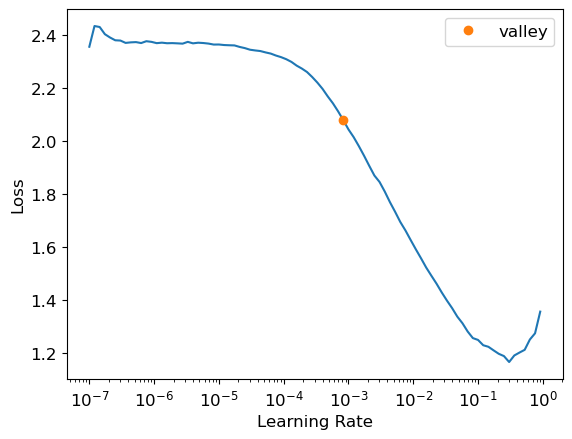

In [18]:
learn.lr_find()

In [19]:
learn.summary()

TabularModel (Input shape: 64 x 0)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 22             
BatchNorm1d                               44         True      
____________________________________________________________________________
                     64 x 200            
Linear                                    4400       True      
ReLU                                                           
BatchNorm1d                               400        True      
____________________________________________________________________________
                     64 x 100            
Linear                                    20000      True      
ReLU                                                           
BatchNorm1d                               200        True      
____________________________________________________________________________
                     64 x 10             
Linear                                    1010       T

In [20]:
learn.fine_tune(12)

epoch,train_loss,valid_loss,time
0,0.079838,0.063419,02:38
1,0.076686,0.063653,02:39
2,0.075939,0.063485,02:40
3,0.075616,0.066356,02:39
4,0.070340,0.061096,02:40
5,0.069366,0.060150,02:40
6,0.061258,0.057393,02:39
7,0.064323,0.056176,02:39
8,0.060216,0.056082,02:40
9,0.054889,0.053262,02:40


In [21]:
preds,targs = learn.get_preds()
preds,targs

(tensor([[1.2655e-01, 3.0652e-06, 1.4367e-04,  ..., 3.4247e-09, 6.1389e-08, 6.3008e-08],
         [2.8537e-05, 2.6890e-05, 9.9900e-01,  ..., 6.6733e-07, 1.8475e-08, 1.7957e-08],
         [3.2438e-08, 1.4556e-10, 1.9807e-07,  ..., 9.9999e-01, 5.0825e-09, 4.9127e-09],
         ...,
         [7.8747e-07, 4.5148e-08, 6.2562e-07,  ..., 9.9999e-01, 3.7701e-08, 3.5450e-08],
         [3.7976e-09, 9.0854e-09, 1.8313e-08,  ..., 2.1418e-08, 1.4812e-09, 1.5982e-09],
         [1.0646e-05, 5.4057e-10, 4.5346e-08,  ..., 1.4008e-07, 4.5660e-09, 4.3714e-09]]),
 tensor([[0],
         [2],
         [7],
         ...,
         [7],
         [3],
         [5]], dtype=torch.int8))

In [22]:
error_rate(preds, targs)

TensorBase(0.0181)

In [23]:
learn.export(output_name)

# Variable Importance

In [3]:
learn = load_learner('../models/DISCOV_BiCOME.pkl')

In [10]:
print(learn.summary())

ValueError: This DataLoader does not contain any batches

In [21]:
class PermutationImportance():
  "Calculate and plot the permutation importance"
  def __init__(self, learn:Learner, df=None, bs=None):
    "Initialize with a test dataframe, a learner, and a metric"
    self.learn = learn
    self.df = df
    bs = bs if bs is not None else learn.dls.bs
    if self.df is not None:
      self.dl = learn.dls.test_dl(self.df, bs=bs)
    else:
      self.dl = learn.dls[1]
    self.x_names = learn.dls.x_names.filter(lambda x: '_na' not in x)
    self.na = learn.dls.x_names.filter(lambda x: '_na' in x)
    self.y = dls.y_names
    self.results = self.calc_feat_importance()
    self.plot_importance(self.ord_dic_to_df(self.results))

  def measure_col(self, name:str):
    "Measures change after column shuffle"
    col = [name]
    if f'{name}_na' in self.na: col.append(name)
    orig = self.dl.items[col].values
    perm = np.random.permutation(len(orig))
    self.dl.items[col] = self.dl.items[col].values[perm]
    metric = learn.validate(dl=self.dl)[0]
    self.dl.items[col] = orig
    return metric

  def calc_feat_importance(self):
    "Calculates permutation importance by shuffling a column on a percentage scale"
    print('Getting base error')
    base_error = self.learn.validate(dl=self.dl)[0]
    self.importance = {}
    pbar = progress_bar(self.x_names)
    print('Calculating Permutation Importance')
    for col in pbar:
      self.importance[col] = self.measure_col(col)
    for key, value in self.importance.items():
      self.importance[key] = abs((base_error-value)/base_error) #this can be adjusted
    return OrderedDict(sorted(self.importance.items(), key=lambda kv: kv[1], reverse=True))

  def ord_dic_to_df(self, dict:OrderedDict):
    return pd.DataFrame([[k, v] for k, v in dict.items()], columns=['feature', 'importance'])

  def plot_importance(self, df:pd.DataFrame, limit=25, asc=False, **kwargs):
    "Plot importance with an optional limit to how many variables shown"
    df_copy = df.copy()
    df_copy['feature'] = df_copy['feature'].str.slice(0,25)
    df_copy = df_copy.sort_values(by='importance', ascending=asc)[:limit].sort_values(by='importance', ascending=not(asc))
    ax = df_copy.plot.barh(x='feature', y='importance', **kwargs)
    for p in ax.patches:
      ax.annotate(f'{p.get_width():.4f}', ((p.get_width() * 1.005), p.get_y()  * 1.005))

In [22]:
learn.dls.vocab

['Bare_Sediment', 'Clorophyta', 'Deep_Sediment', 'Low_SPC', 'MPB', 'Magnoliosida', 'Phaeophyta', 'Rhodphyta', 'SunGlint', 'Water']

Getting base error


Calculating Permutation Importance


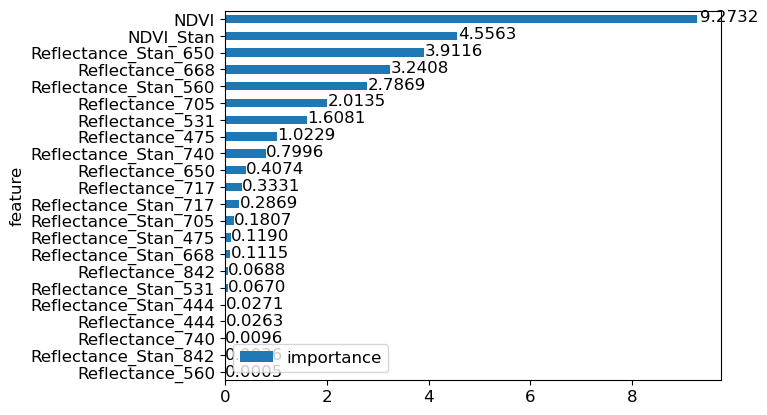

In [23]:
Seagrass = df_nn.loc[df_nn['True_Class'] == 'Magnoliosida']
res_Seagrass = PermutationImportance(learn,Seagrass)

Getting base error


Calculating Permutation Importance


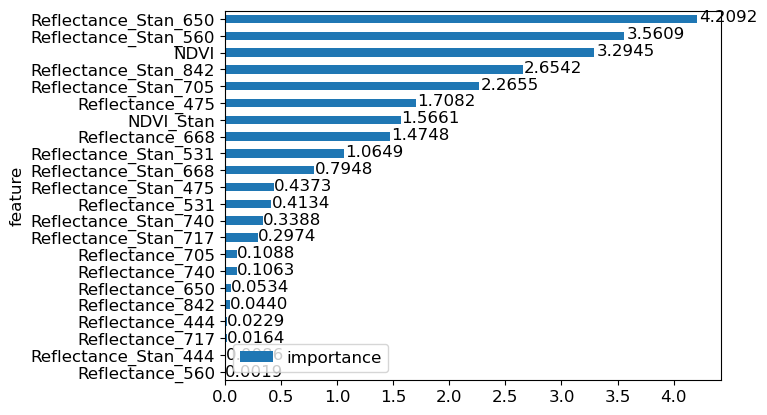

In [24]:
Low_SPC = df_nn.loc[df_nn['True_Class'] == 'Low_SPC']
res_Low_SPC = PermutationImportance(learn,Low_SPC)

Getting base error


Calculating Permutation Importance


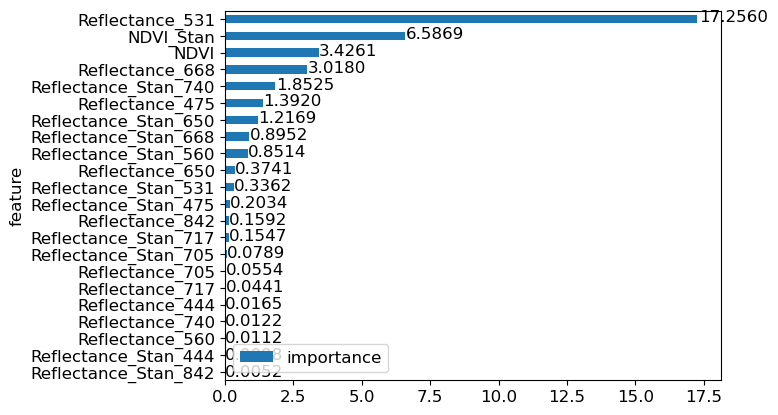

In [25]:
Clorophyta = df_nn.loc[df_nn['True_Class'] == 'Clorophyta']
res_Clorophyta = PermutationImportance(learn,Clorophyta)

Getting base error


Calculating Permutation Importance


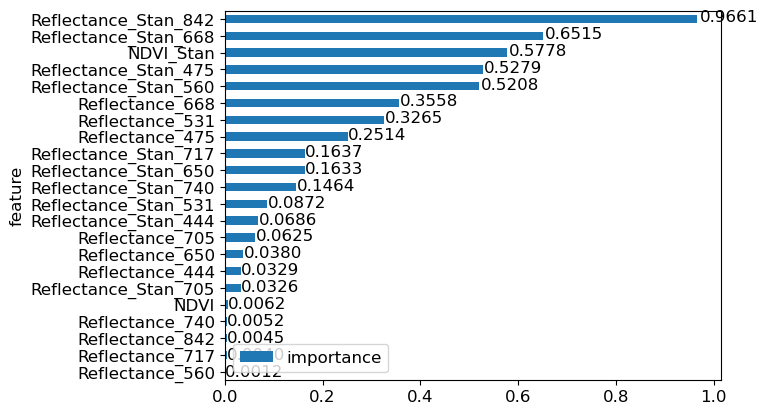

In [26]:
Bare_Sediment = df_nn.loc[df_nn['True_Class'] == 'Bare_Sediment']
res_Bare_Sediment = PermutationImportance(learn,Bare_Sediment)

Getting base error


Calculating Permutation Importance


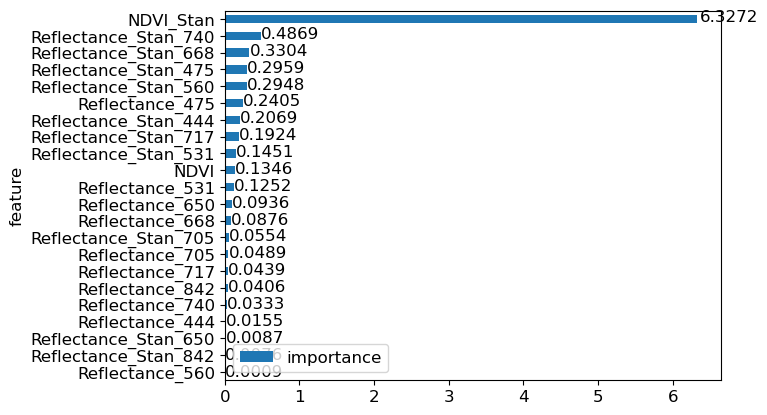

In [27]:
Deep_Sediment = df_nn.loc[df_nn['True_Class'] == 'Deep_Sediment']
res_Deep_Sediment = PermutationImportance(learn,Deep_Sediment)

Getting base error


Calculating Permutation Importance


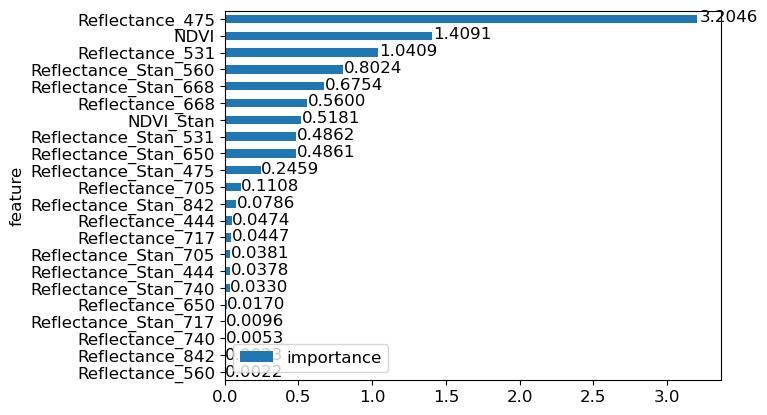

In [28]:
MPB = df_nn.loc[df_nn['True_Class'] == 'MPB']
res_MPB = PermutationImportance(learn,MPB)

Getting base error


Calculating Permutation Importance


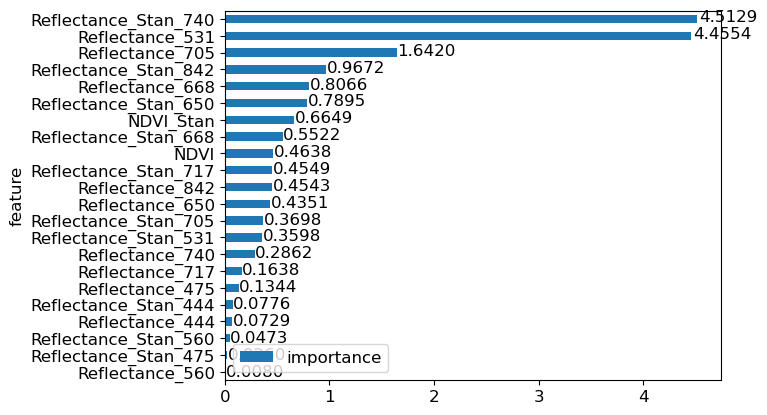

In [29]:
Phaeophyta = df_nn.loc[df_nn['True_Class'] == 'Phaeophyta']
res_Phaeophyta = PermutationImportance(learn,Phaeophyta)

Getting base error


Calculating Permutation Importance


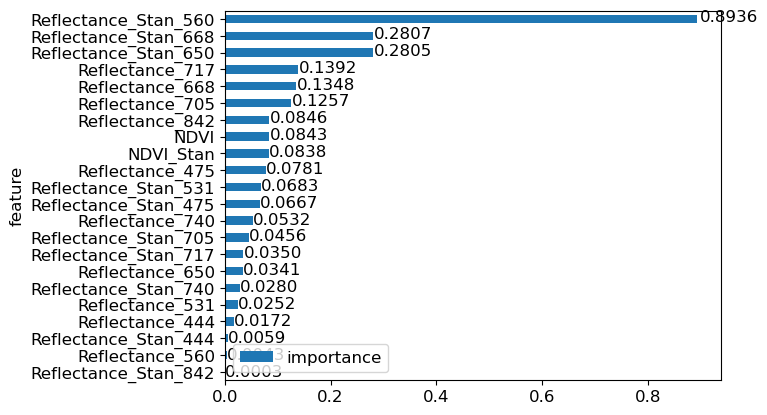

In [30]:
Rhodphyta = df_nn.loc[df_nn['True_Class'] == 'Rhodphyta']
res_Rhodphyta = PermutationImportance(learn,Rhodphyta)

Getting base error


Calculating Permutation Importance


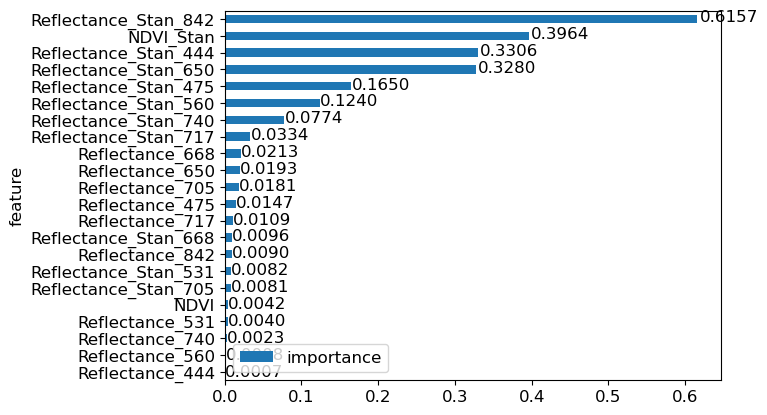

In [31]:
Water = df_nn.loc[df_nn['True_Class'] == 'Water']
res_Water = PermutationImportance(learn,Water)

Getting base error


Calculating Permutation Importance


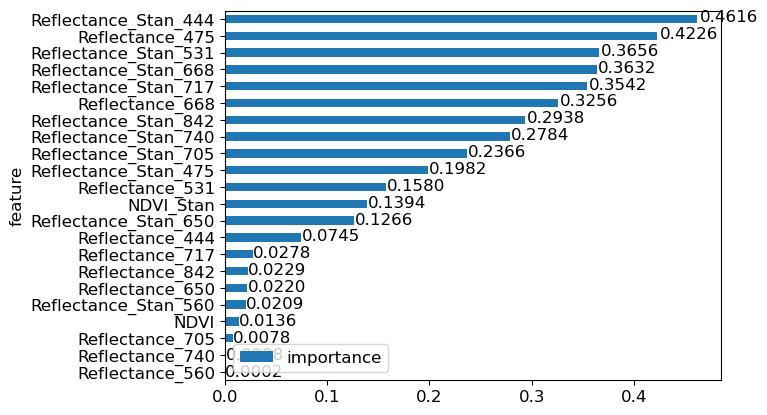

In [32]:
SunGlint = df_nn.loc[df_nn['True_Class'] == 'SunGlint']
res_SunGlint = PermutationImportance(learn,SunGlint)

Getting base error


Calculating Permutation Importance


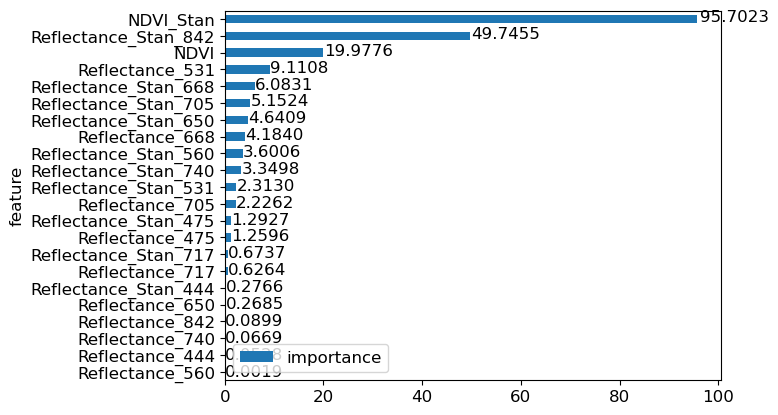

In [33]:
res_Total = PermutationImportance(learn,df_nn)

In [34]:
VIP= (pd.Series(res_Seagrass.importance).to_frame('Magnoliosida')
           .join(pd.Series(res_Low_SPC.importance).to_frame('Low_SPC'), how='outer')
     
           .join(pd.Series(res_Clorophyta.importance).to_frame('Clorophyta'), how='outer')
          
           .join(pd.Series(res_Bare_Sediment.importance).to_frame('Bare_Sediment'), how='outer')
     
           .join(pd.Series(res_Deep_Sediment.importance).to_frame('Deep_Sediment'), how='outer')
     
           .join(pd.Series(res_MPB.importance).to_frame('MPB'), how='outer')
     
           .join(pd.Series(res_Phaeophyta.importance).to_frame('Phaeophyta'), how='outer')
     
           .join(pd.Series(res_Rhodphyta.importance).to_frame('Rhodphyta'), how='outer')
     
           .join(pd.Series(res_Water.importance).to_frame('Water'), how='outer')
     
           .join(pd.Series(res_SunGlint.importance).to_frame('SunGlint'), how='outer')
     
           .join(pd.Series(res_Total.importance).to_frame('Total'), how='outer'))

In [35]:
VIP.to_csv("Data/Output/NN_VIP_byClass_NoXanth.csv")